# Langevin system simulator [Data analysis]
A notebook to replicate results of https://aapt.scitation.org/doi/10.1119/1.4772632

In [1]:
%matplotlib notebook

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os

Set the working directory

In [2]:
cwd = os.path.join(os.getcwd(),"SAMPLE")

## Part I : Free diffusion

In [3]:
class freediff:
    def __init__(self, file):
        with open(os.path.join(cwd,file), "r") as f :
            fd = f.readlines()
        ff = list(zip(*[i.split('\t') for i in fd]))[0:3]
        self.x, self.w, self.t = np.array(ff, dtype=float)

<IPython.core.display.Javascript object>


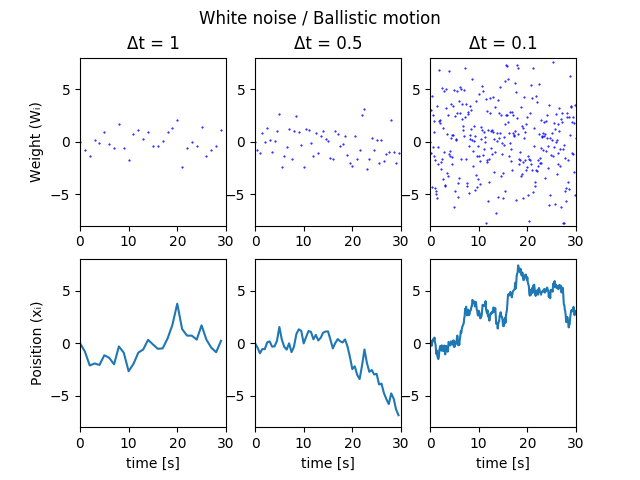

In [4]:
ffd1 = freediff("FreeDiff_30_1.000.out")
ffd2 = freediff("FreeDiff_60_0.500.out")
ffd3 = freediff("FreeDiff_300_0.100.out")

fig, axs = plt.subplots(2, 3)
fig.suptitle("White noise / Ballistic motion")
axs[0, 0].plot(ffd1.t, ffd1.w, 'bo', markersize=0.5)
axs[0, 0].set_ylim([-8,8])
axs[0, 0].set_title('Δt = 1')
axs[0, 0].set(ylabel='Weight (Wᵢ)')

axs[1, 0].plot(ffd1.t, ffd1.x)
axs[1, 0].set(ylabel='Poisition (xᵢ)')

axs[0, 1].plot(ffd2.t, ffd2.w, 'bo', markersize=0.5)
axs[0, 1].set_ylim([-8,8])
axs[0, 1].set_title('Δt = 0.5')
axs[1, 1].plot(ffd2.t, ffd2.x)

axs[0, 2].plot(ffd3.t, ffd3.w, 'bo', markersize=0.5)
axs[0, 2].set_ylim([-8,8])
axs[0, 2].set_title('Δt = 0.1')
axs[1, 2].plot(ffd3.t, ffd3.x)

for ax in axs.flat:
    ax.set_xlim([0,30])
    
for ax in axs[1]:
    ax.set(xlabel='time [s]')
    ax.set_ylim([-8,8])


## Part II : Brownian diffusion

In [19]:
# Generic helper functions
def acorr(x,normed=True, maxlags=None):
    # Based on https://matplotlib.org/3.1.1/_modules/matplotlib/axes/_axes.html#Axes.acorr
    Nx = len(x)
    c = np.correlate(x, x, mode='full')

    if normed:
        n = np.sqrt(np.dot(x, x) * np.dot(x, x)) # this is the transformation function
        c = np.true_divide(c,n)

    if maxlags is None:
        maxlags = Nx - 1

    if maxlags >= Nx or maxlags < 1:
        raise ValueError('Illegal maxlag')

    lags = np.arange(-maxlags, maxlags + 1)
    c = c[Nx - 1 - maxlags:Nx + maxlags]
    return lags, c

def vac(x, dt = 1e-8):
    v = np.abs(np.array(x[1:] - x[:-1])/dt)
    lags, cor = acorr(v,normed=True,maxlags=int(np.ceil(np.sqrt(len(x)))))
    return cor

def xsq(x,n):
    assert(n>0)
    if n==1 : return np.mean(np.square(x - x))
    else : return np.mean(np.square(x[n-1:] - x[:1-n]))
    
# Class definition

class bdiff:
    def __init__(self, file):
        with open(os.path.join(cwd,file), "r") as f :
            lines = f.readlines()
        lines = list(zip(*[i.split('\t') for i in lines]))[0:3]
        self.xa, self.xi, self.t = np.array(lines, dtype=float)
        self.dt = float(file.replace(".out", "").split("_")[2])
    def xsqi(self):
        return [xsq(self.xi, i) for i in range(1,len(self.xi))]
    def xsqa(self):
        return [xsq(self.xa, i) for i in range(1,len(self.xa))]
    def cvis(self):
        return vac(self.xi, self.dt)
    def cvas(self):
        return vac(self.xa, self.dt)

<IPython.core.display.Javascript object>


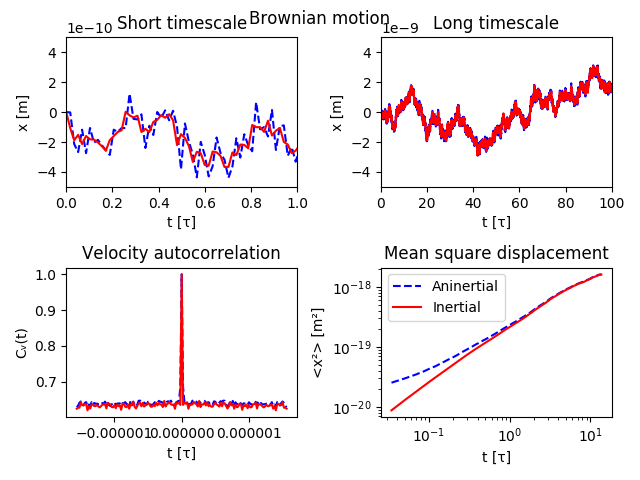

In [20]:
bd = bdiff("BrownDiff_6000_1e-08.out")

fig, axs = plt.subplots(2, 2)
fig.suptitle("Brownian motion")
                   
axs[0, 0].plot(bd.t[:61], bd.xa[:61],'b--')
axs[0, 0].plot(bd.t[:61], bd.xi[:61],'r')
axs[0, 0].set_ylim([-0.5e-9,0.5e-9])
axs[0, 0].set_xlim([0,1])
axs[0, 0].set_title('Short timescale')
axs[0, 0].set(ylabel='x [m]', xlabel="t [τ]")
                   
axs[0, 1].plot(bd.t, bd.xa,'b--')
axs[0, 1].plot(bd.t, bd.xi,'r')
axs[0, 1].set_ylim([-5e-9,5e-9])
axs[0, 1].set_xlim([0,100])
axs[0, 1].set_title('Long timescale')
axs[0, 1].set(ylabel='x [m]', xlabel="t [τ]")


axs[1, 0].plot(bd.dt * np.arange(1-len(bd.cvas()),len(bd.cvas())+1,2), bd.cvas(),'b--')
axs[1, 0].plot(bd.dt * np.arange(1-len(bd.cvis()),len(bd.cvis())+1,2), bd.cvis(),'r')
axs[1, 0].set_title('Velocity autocorrelation')
axs[1, 0].set(ylabel='Cᵥ(t)', xlabel="t [τ]")

axs[1, 1].loglog(bd.t[2:800], bd.xsqa()[2:800],'b--', label='Aninertial')
axs[1, 1].loglog(bd.t[2:800], bd.xsqi()[2:800],'r', label='Inertial')
axs[1, 1].set_title('Mean square displacement')
axs[1, 1].set(ylabel='<x²> [m²]', xlabel="t [τ]")
axs[1, 1].legend()

plt.tight_layout()

## Part III : Optical trap

In [7]:
class otrap:
    def __init__(self, file):
        with open(os.path.join(cwd,file), "r") as f :
            lines = f.readlines()
        rs = list(zip(*[i.split('\t') for i in lines]))[0:4]
        self.x, self.y, self.z, self.t = np.array(rs, dtype=float)
        self.kx, self.ky, self.kz = [float(i) for i in file[file.find("[")+1:file.find("]")].split("_")]
        
    def varxy(self):
        ar = np.sqrt(np.square(self.x) + np.square(self.y))
        return np.var(ar)
    
    def varzy(self):
        ar = np.sqrt(np.square(self.z) + np.square(self.y))
        return np.var(ar)
    
    def varzx(self):
        ar = np.sqrt(np.square(self.z) + np.square(self.x))
        return np.var(ar)
    
    def msqd(self, param = 'x'):
        if param == 'x' : pa = self.x
        elif param == 'y' : pa = self.y
        elif param == 'z' : pa = self.z
        else: raise Exception("Illegal parameter {}".format(param))
        return [xsq(pa, i) for i in range(1,len(pa))]
    def poscorr(self, param='x'):
        if param == 'x' : pa = self.x
        elif param == 'y' : pa = self.y
        elif param == 'z' : pa = self.z
        return acorr(pa ,maxlags=None)

<IPython.core.display.Javascript object>


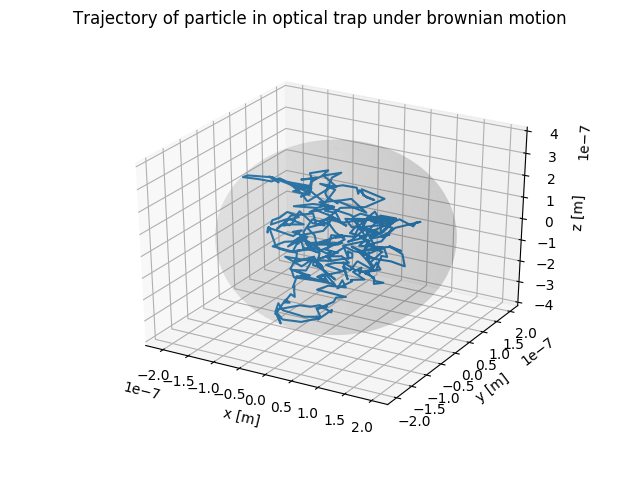

In [8]:
TRAJ_LIM = 400

otrap1 = otrap("OptTrap_100000_0.001_5.84e-07_[1e-06_1e-06_2e-07].out")

fig = plt.figure()
fig.suptitle("Trajectory of particle in optical trap under brownian motion")
ax = fig.add_subplot(111, projection='3d')

# Make ellipsoid
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = 200e-9 * np.outer(np.cos(u), np.sin(v))
y = 200e-9 * np.outer(np.sin(u), np.sin(v))
z = 400e-9 * np.outer(np.ones(np.size(u)), np.cos(v))

# Plot the surface
ax.plot_surface(x, y, z, color='grey', alpha=0.1)
ax.set(ylabel='y [m]', xlabel="x [m]", zlabel="z [m]")
# ax.auto_scale_xyz([-200e-9, 200e-9], [-200e-9, 200e-9], [-400e-9, 400e-9])
ax.plot(otrap1.x[:TRAJ_LIM], otrap1.y[:TRAJ_LIM], otrap1.z[:TRAJ_LIM])

<IPython.core.display.Javascript object>


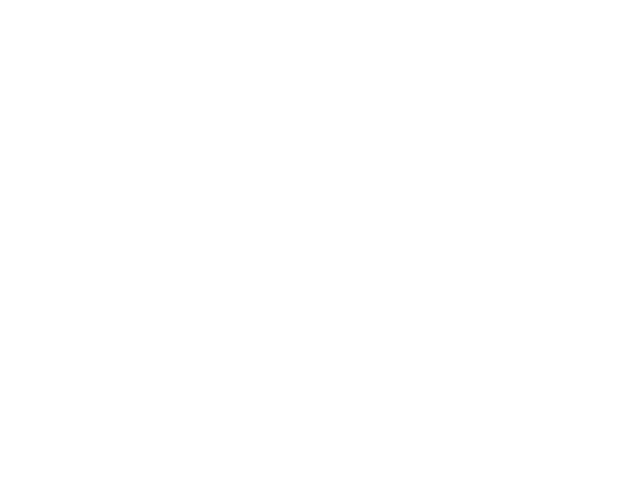

<IPython.core.display.Javascript object>


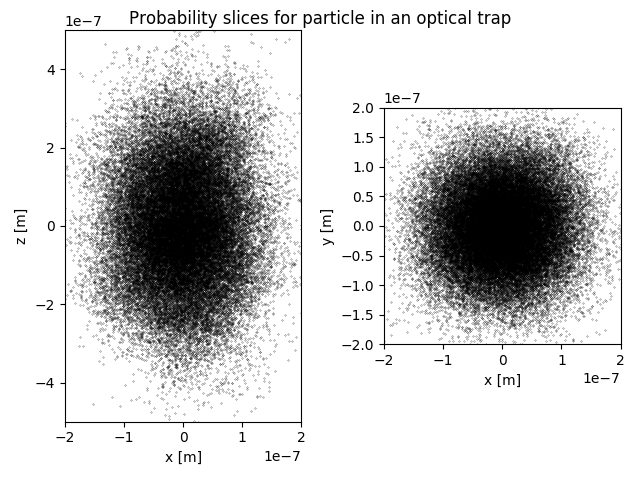

In [9]:
XY_PLOT_LIM = 50000


plt.figure()
fig, axs = plt.subplots(1,2)
fig.suptitle("Probability slices for particle in an optical trap")

axs[0].plot(otrap1.x[:XY_PLOT_LIM], otrap1.z[:XY_PLOT_LIM], 'ko', markersize=0.2)
axs[0].set_xlim([-200e-9,200e-9])
axs[0].set_ylim([-500e-9,500e-9])
axs[0].set_aspect('auto')
axs[0].set(xlabel='x [m]', ylabel='z [m]')

axs[1].plot(otrap1.x[:XY_PLOT_LIM],otrap1.y[:XY_PLOT_LIM], 'ko', markersize=0.2)
axs[1].set_ylim([-200e-9,200e-9])
axs[1].set_xlim([-200e-9,200e-9])
axs[1].set_aspect('1')
axs[1].set(xlabel='x [m]', ylabel='y [m]')
plt.tight_layout()

<IPython.core.display.Javascript object>


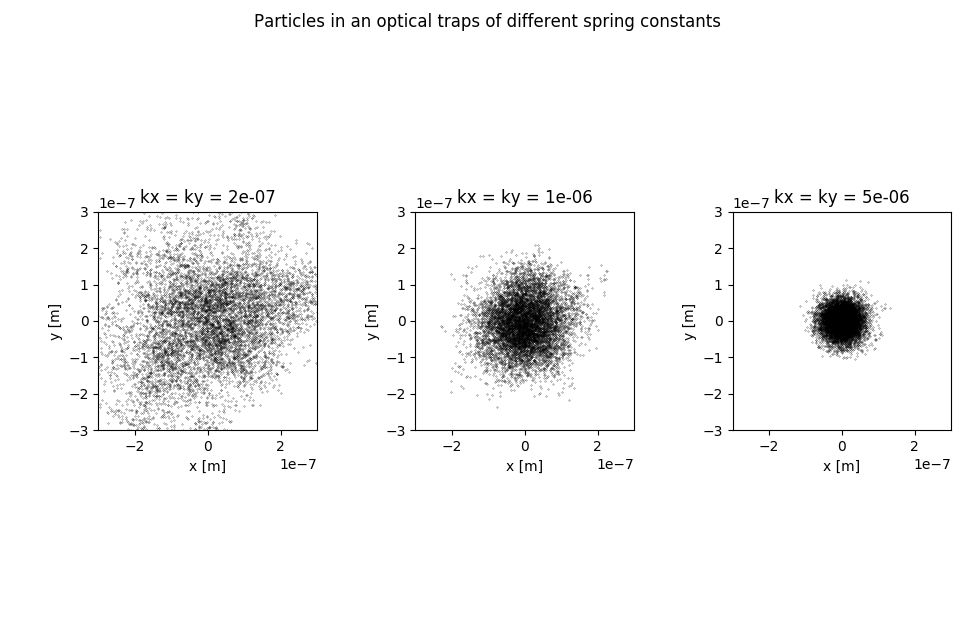

In [15]:
SYM_XY_PLOT_LIM = 8000

symotraps = []
symotraps.append(otrap("OptTrap_100000_0.001_5.84e-07_[2e-07_2e-07_2e-07].out"))
symotraps.append(otrap("OptTrap_100000_0.001_5.84e-07_[1e-06_1e-06_1e-06].out"))
symotraps.append(otrap("OptTrap_100000_0.001_5.84e-07_[5e-06_5e-06_5e-06].out"))

fig, axs = plt.subplots(1,3)      
fig.suptitle("Particles in an optical traps of different spring constants")

for i in range(3):
    axs[i].plot(symotraps[i].x[:SYM_XY_PLOT_LIM], symotraps[i].y[:SYM_XY_PLOT_LIM], 'ko', markersize=0.2)
    axs[i].set_xlim([-300e-9,300e-9])
    axs[i].set_ylim([-300e-9,300e-9])
    axs[i].set_aspect(1)
    axs[i].set_title('kx = ky = {}'.format(symotraps[i].kx))
    axs[i].set(xlabel='x [m]', ylabel='y [m]')
plt.tight_layout()

<IPython.core.display.Javascript object>


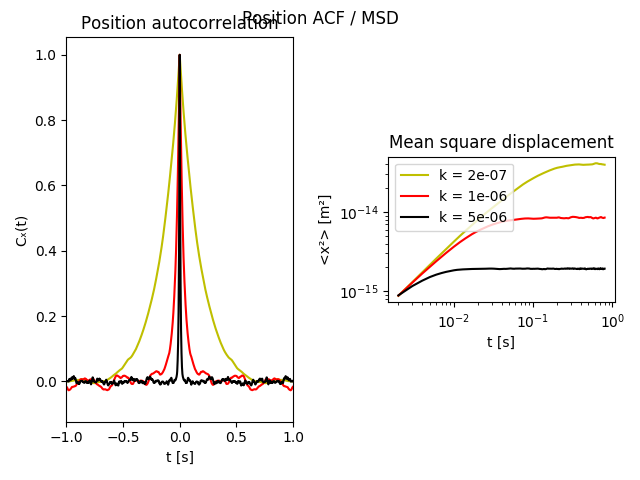

In [16]:
fig, axs = plt.subplots(1, 2)
fig.suptitle("Position ACF / MSD")

axs[0].set_title('Position autocorrelation')
axs[0].set(ylabel='Cₓ(t)', xlabel="t [s]")
axs[0].set_xlim([-1,1])

axs[1].set_title('Mean square displacement')
axs[1].set(ylabel='<x²> [m²]', xlabel="t [s]")
axs[1].set_aspect(1)

for i in range(3):
    if i==0 : cs = "y"
    elif i==1 : cs = "r"
    elif i==2 : cs = "k"
    _, cxs = symotraps[i].poscorr()
    axs[0].plot(symotraps[i].t[1] * np.arange(1-len(cxs),len(cxs)+1,2), cxs, cs)
    axs[1].loglog(symotraps[i].t[2:800], symotraps[i].msqd()[2:800], cs, label="k = {}".format(symotraps[i].kx))
#     axs[2].plot(symotraps[i].x[:SYM_XY_PLOT_LIM], symotraps[i].y[:SYM_XY_PLOT_LIM], 'ko', markersize=0.2)
    
axs[1].legend()
plt.tight_layout()

In [12]:
otraps = []
for pf in os.listdir(cwd):
    if not pf.startswith('OptTrap') : continue
    otraps.append(otrap(pf))
otraps = list(filter(lambda z : z.kx == z.ky, otraps))
kxy = [i.kx for i in otraps]
sxy = [i.varxy() for i in otraps]

<IPython.core.display.Javascript object>


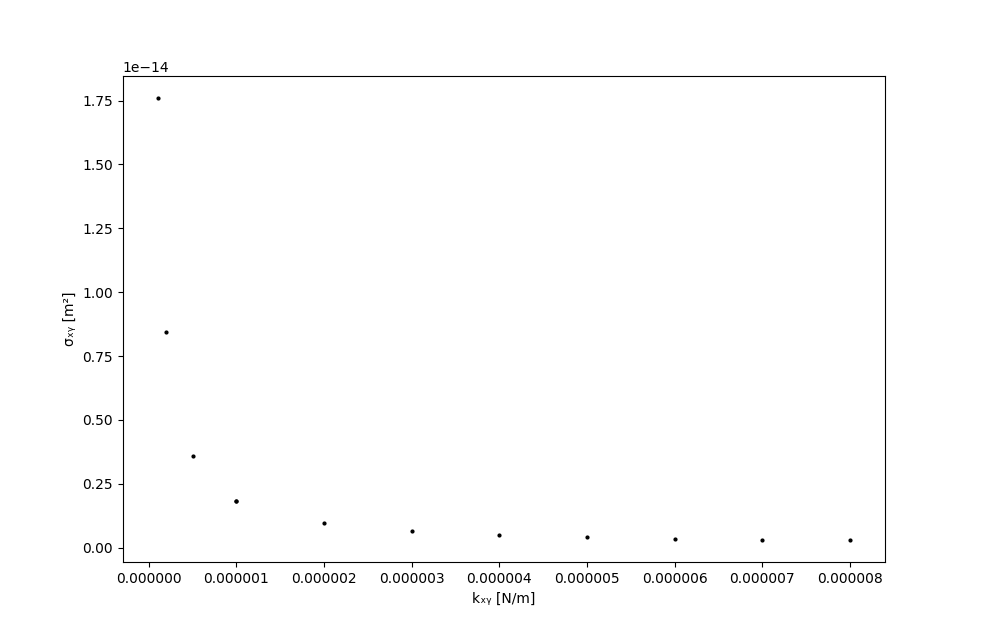

In [13]:
plt.figure()
plt.plot(kxy, sxy, "ko", markersize=2)
plt.ylabel('σₓᵧ [m²]')
plt.xlabel('kₓᵧ [N/m]')
plt.show()